When training a graph neural network, we like to train them in a mini-batch fashion. When we need to scale the training to a large graph for GPU training, we need to keep node/edge data in CPU and stream data to GPU. Potentially, we can deploy a cache in GPU to reduce the amount of data sent to GPU.

This notebook studies the potential cache hits for the mini-batch training in the GPU cache. This study assumes we use neighbor sampling to generate mini-batches and the neighbors are sampled uniformly at random. Apparently, the cache hits very much depend on the datasets.

In [1]:
import dgl

Using backend: pytorch
/home/ubuntu/workspace/dgl-gpu/python/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


## Study with the OGB product graph

This is commonly used benchmark for many graph neural networks.

In [2]:
from ogb.nodeproppred import DglNodePropPredDataset

data = DglNodePropPredDataset(name='ogbn-products')
g, _ = data[0]
print(g)

/home/ubuntu/workspace/dgl-gpu/python/dgl/base.py:45: DGLWarning: You are loading a graph file saved by old version of dgl.              Please consider saving it again with the current format.
  return warnings.warn(message, category=category, stacklevel=1)


Graph(num_nodes=2449029, num_edges=123718280,
      ndata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}
      edata_schemes={})


Now let's study if the graph has power-law distribution on degree.

In [3]:
indeg = g.in_degrees().numpy()

In [4]:
import numpy as np
np.histogram(indeg)

(array([2448276,     649,      70,      21,      10,       2,       0,
              0,       0,       1]),
 array([    0. ,  1748.1,  3496.2,  5244.3,  6992.4,  8740.5, 10488.6,
        12236.7, 13984.8, 15732.9, 17481. ]))

In [5]:
indeg = np.sort(indeg)
ratio = []
for i in range(10):
    r = np.sum(indeg[int(len(indeg)/10*(9-i)):])/np.sum(indeg)
    ratio.append(r)
print(ratio)

[0.44898310096131305, 0.6309086983750501, 0.7553002353411314, 0.8441343510433543, 0.9062882461670175, 0.9472815254140293, 0.9732538150384891, 0.9891124981692277, 0.9975905096643762, 1.0]


The degree of this graph isn't very skewed compared with many other graphs, but the 10% largest-degree nodes have edges that account for close to 50%.

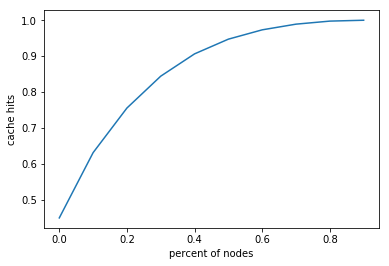

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.arange(10)*0.1, np.array(ratio))
plt.ylabel('cache hits')
plt.xlabel('percent of nodes')
plt.show()

## Simulate cache hits

One effective way of caching nodes in a power-law graph is to use LFU (least-frequently used). The simulation here is to basically keep the highest-degree nodes in the cache and see what cache hits it can generate. This simulation should generate the lower bound of the cache hits.

In [8]:
def cache_hits(cnts, ratio):
    indeg = g.in_degrees().numpy()
    indeg1 = np.sort(indeg)
    deg_threshold = indeg1[int(len(indeg1) * (1-ratio))]
    return np.sum(cnts[indeg > deg_threshold])/np.sum(cnts)

We study cache hits for 2-layer GNN. If we cache node features, the cache hits also depend on how GNN uses node features. Typical GNN such as GCN only reads node features in the first layer (farthest away from the target nodes). But it's possible that some GNNs read node features in all layers. Therefore, I calculate the cache hits for both cases.

Another factor can also affect the cache hit ratio. That is the batch size. The reason that batch size affects the cache hits is that in each layer we only read the features of a node once no matter how many times it appears in some nodes' neighborhood. Therefore, when the batch size is large, large-degree nodes appear many times in a layer but it only reads once. This reduces the cache hit ratio of the large-degree nodes.

We can see that when the batch size is small, such as 10, the cache hit ratio is significantly higher, especially for the first layer. The reason that the batch size affects the cache hits so much is that the graph is very small. Its impact on a large graph will be much smaller unless we want to use very large batch size.

Another thing we can notice is that the simulated cache hit ratio doesn't really follow the degree distribution. The previous calculation shows that the 10% largest-degree nodes have edges that account for close to 50%. However, if we cache the 10% large-degree nodes, we only get roughly 36% cache hits. This may suggest that the high-degree nodes are not well connected. In other words, a high-degree tends to connect with lower-degree nodes in Reddit. This is not necessary true in other datasets. More study is needed.

In [11]:
num_neighbors = [10, 10]
for batch_size in [100, 1000, 10000]:
    last_layer_cnts = np.zeros(g.number_of_nodes())
    first_layer_cnts = np.zeros(g.number_of_nodes())

    sampler = dgl.dataloading.MultiLayerNeighborSampler(num_neighbors)
    dataloader = dgl.dataloading.NodeDataLoader(g,
                                                np.arange(g.number_of_nodes()),
                                                sampler,
                                                batch_size=batch_size,
                                                drop_last=False,
                                                num_workers=4)
    for input_nodes, seeds, blocks in dataloader:
        last_layer_cnts[seeds] += 1
        first_layer_cnts[input_nodes] += 1
    print('batch size: {}'.format(batch_size))
    print('Cache hits on the first layer:', cache_hits(last_layer_cnts, 0.1))
    print('Cache hits on the layer next to the target nodes:', cache_hits(first_layer_cnts, 0.1))

batch size: 100
Cache hits on the first layer: 0.09868482570030816
Cache hits on the layer next to the target nodes: 0.36908059298661156
batch size: 1000
Cache hits on the first layer: 0.09868482570030816
Cache hits on the layer next to the target nodes: 0.3524177710798187
batch size: 10000
Cache hits on the first layer: 0.09868482570030816
Cache hits on the layer next to the target nodes: 0.2715501157416558
